# Tabular Sarsa Algorithm and the Taxi Environment

Tabular methods are suitable for small and discrete state space and discrete action space environments. So, the state-action function (Q) can be represented by a table of values. For large state space environments, we prefer to use approximation methods such as neural networks. However, the simplicity of tabular methods' implementation is helpful to demonstrate RL method's functionality. 

In this notebook, we train a SARSA agent for the OpenAI Gym's Taxi environment. The taxi agent's job is to pick up the passenger in a simplified gridworld like environment at one location and drop them off in another ([Taxi, OpenAI Gym](https://gym.openai.com/envs/Taxi-v2/)). Here are a few things that we'd like our Smartcab to take care of:

- Drop off the passenger to the right location.
- Save passenger's time by taking minimum time possible to drop off
- Take care of passenger's safety and traffic rules

__State__: Let's say we have a training area for our Smartcab where we are teaching it to transport people in a parking lot to four different locations (R, G, Y, B):

Let's assume Smartcab is the only vehicle in this parking lot. We can break up the parking lot into a 5x5 grid, which gives us 25 possible taxi locations. These 25 locations are one part of our state space. Notice the current location state of our taxi is coordinate (3, 1).

You'll also notice there are four (4) locations that we can pick up and drop off a passenger: R, G, Y, B or `[(0,0), (0,4), (4,0), (4,3)]` in (row, col) coordinates. Our illustrated passenger is in location Y and they wish to go to location R.

__Actions__: The agent is allowed to perform six possible actions:

1. south
2. north
3. east
4. west
5. pickup
6. dropoff

Notice in this environment the taxi cannot perform certain actions in certain states due to walls. In environment's code, we will simply provide a -1 penalty for every wall hit and the taxi won't move anywhere. This will just rack up penalties causing the taxi to consider going around the wall.

## 1- Installations

In [1]:
# PLEASE RUN ME!
# INSTALLATIONS
!pip -q install gym numpy matplotlib 

## 2- Loading the Environment

In [1]:
import gym

# Finding the Taxi environment
for env in gym.envs.registry.all():
    if env.id.startswith("Taxi"):
        env_name = env.id
##

print("Environment Name:", env_name)
env = gym.make(env_name)
env.reset()
env.render()

Environment Name: Taxi-v3
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



## 3- Developing the SARSA agent

<img src="figures/SARSA_algorithm.png" width="800">

Here's the full update formula covered in line 7 and 8:
<img src="figures/SARSA_formula.png" width="500">

In [2]:
import numpy as np
import pickle

class Sarsa_Agent:
    def __init__(self, states_n, actions_n, learning_rate=0.2, epsilon=0.1, gamma=0.95, epsilon_decay=True,
                 epsilon_decay_factor=0.01):
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.gamma = gamma
        self.states_n = states_n
        self.actions_n = actions_n
        self.Q = np.zeros((states_n, actions_n))
        self.new_a = None
        self.epsilon_decay = epsilon_decay
        self.epsilon_decay_factor = epsilon_decay_factor

    def act(self, state):
        """The act method implements the epsilon-greedy policy"""
        if np.random.rand() < self.epsilon:
            act = np.random.choice(np.arange(self.actions_n))
        else:
            act = np.argmax(self.Q[int(state), :])
        return act

    def decay_epsilon(self, factor):
        """Decaying the epsilon, so it gradualy reduces the exploration and exploits more"""
        self.epsilon -= factor if self.epsilon >= 0 else 0

    def update(self, new_s, r, s, a, done):
        """The update method updates the agent for one step"""
        self.new_a = self.act(new_s)
        mask = 0 if done else 1
        s, a, self.new_a, new_s = int(s), int(a), int(self.new_a), int(new_s)
        self.Q[s, a] += self.learning_rate * (r + self.gamma * self.Q[new_s, self.new_a] * mask - self.Q[s, a])
        if done and self.epsilon_decay:
            self.decay_epsilon(self.epsilon_decay_factor)
        return self.new_a

    def save(self, file_name="taxi.pkl"):
        """The save method saves (pickles) the agent's Q table"""
        with open(file_name, mode="wb") as f:
            pickle.dump(self.Q, f)

    def load(self, file_name="taxi.pkl"):
        """The load method loads a pickled Q table"""
        with open(file_name, mode="rb") as f:
            self.Q = pickle.load(f)

## 4- Defining the Training Loop

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from time import sleep
import numpy as np

def train_taxi(env, agent, episodes=150):
    if env is None:
        raise ValueError("No Environment is given.")
    if agent is None:
        raise ValueError("No agent is given.")

    steps = []
    returns = []
    for episode in range(episodes):
        state = env.reset()
        action = agent.act(state)
        done = False
        step_n = 0
        return_episode = 0
        while not done:
            new_state, reward, done, _ = env.step(action)
            return_episode += reward
            new_action = agent.update(new_state,reward,state,action,done)
            state, action = new_state, new_action
            step_n += 1
            if done:
                steps.append(step_n)
                returns.append(return_episode)
                clear_output(wait=True)
                plt.title("Steps:" + str(step_n) + " Return:"+str(return_episode))
                plt.plot(list(range(len(steps))),steps)
                plt.plot(list(range(len(steps))),returns)
                plt.legend(["Steps", "Returns"])
                plt.show()

## 5- Let's train our agent for 1500 episodes (takes ~5 minutes)

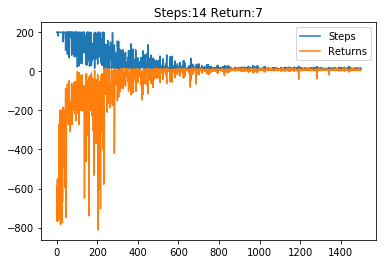

In [4]:
agent = Sarsa_Agent(env.observation_space.n, env.action_space.n,epsilon_decay=True)

train_taxi(env, agent, episodes=1500)
agent.save()

## 6- Methods for Playing and Rendering the Taxi environment in the notebook

In [5]:
def taxi_print_frames(frames, wait_btw_frames, episode):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Passenger #: {episode + 1}")
        print("-----------")
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(wait_btw_frames)
        
def play_taxi(env, agent, passengers=2, wait_btw_frames=1):
    for episode in range(passengers):
        state = env.reset()
        frames = []
        done = False
        step = 0
        while not done:
            action = agent.act(state)
            new_state, reward, done, _ = env.step(action)
            frames.append({
                'frame': env.render(mode='ansi'),
                'state': state,
                'action': action,
                'reward': reward
            })
            step += 1
            state = new_state
        taxi_print_frames(frames, wait_btw_frames=wait_btw_frames, episode=episode)

## 7- Watch a Trained SARSA Cab Driver

Note: You can change the number of passengers if you want to move more than 3. Change the wait_btw_frames if you want to see the game running faster or slower.

In [6]:
play_taxi(env, agent, passengers=3, wait_btw_frames=1)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Passenger #: 3
-----------
Timestep: 17
State: 418
Action: 5
Reward: 20
